# Mohammad Amin Kiani 4043644008

## pc eng - AI 404

### EC-ex2 . ui.ac.ir



## codes:

In [26]:
# =========================
# Cell 0 - Imports & config
# =========================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# تنظیمات نمودارها
plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['axes.grid'] = True
plt.rcParams['font.size'] = 11


In [27]:
# ===============================
# Cell 1 - Load and prepare data
# ===============================

df = pd.read_csv("Dataset.csv")

print("Columns:", df.columns.tolist())
print("Shape:", df.shape)

# نام ستون‌های سهام (همه‌ی ستون‌ها به‌جز Week و Rf)
asset_cols = [c for c in df.columns if c not in ["Week", "Rf"]]
n_assets = len(asset_cols)
print("Number of assets:", n_assets)

# ماتریس بازده هفتگی سهام (T x N)
returns = df[asset_cols].values  # shape: (T, N)

# نرخ بدون ریسک (T x 1)
rf = df["Rf"].values.reshape(-1, 1)

T = returns.shape[0]
print(f"Data has {T} weeks of returns for {n_assets} assets.")


Columns: ['Week', 'AAPL', 'ABT', 'ACN', 'ADBE', 'AMGN', 'AMZN', 'BAC', 'BMY', 'CMCSA', 'COST', 'CSCO', 'CVX', 'DIS', 'GE', 'GOOGL', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'JPM', 'KO', 'LIN', 'MA', 'MCD', 'MDT', 'META', 'MMM', 'MRK', 'MSFT', 'NEE', 'NFLX', 'NKE', 'NVDA', 'ORCL', 'PEP', 'PFE', 'PG', 'QCOM', 'SBUX', 'T', 'TMUS', 'TSLA', 'TXN', 'UNH', 'UPS', 'V', 'VZ', 'WMT', 'XOM', 'Rf']
Shape: (147, 52)
Number of assets: 50
Data has 147 weeks of returns for 50 assets.


In [28]:
# ============================================
# Cell 2 - Chromosome decoding & Sharpe ratio
# ============================================

k_assets = 10  #  ۱۰ سهم در پورتفوی

def decode_portfolio(chrom, k=k_assets):
    """
    chrom: آرایه 1D با طول n_assets، در بازه [0,1]
    خروجی:
        full_w: وزن کامل ۵۰ سهم (مجموع وزن‌های غیرصفر = ۱)
        top_idx: ایندکس ۱۰ سهم انتخاب‌شده
    """
    chrom = np.asarray(chrom, dtype=float)

    # اگر همه صفر شد (به‌دلایل عددی) → دوباره تصادفی
    if np.all(chrom <= 0):
        chrom = np.random.rand(len(chrom))

    # ایندکس ۱۰ ژن بزرگ‌تر
    top_idx = np.argsort(chrom)[-k:]  # آخرین k تا (بزرگ‌ترین‌ها)

    w_raw = chrom[top_idx]
    s = w_raw.sum()
    if s <= 0:
        # اگر جمع صفر شد، وزن مساوی بده
        w_norm = np.ones_like(w_raw) / len(w_raw)
    else:
        w_norm = w_raw / s

    # ساخت بردار وزن کامل ۵۰تایی
    full_w = np.zeros_like(chrom)
    full_w[top_idx] = w_norm

    return full_w, top_idx


def sharpe_ratio_from_weights(w):
    """
    w: وزن ۵۰ سهم (جمع = ۱)
    Sharpe هفتگی را برمی‌گرداند.
    """
    # بازده هفتگی پورتفوی
    port_ret = returns @ w  # shape: (T,)

    # بازده اضافی نسبت به بدون ریسک
    excess = port_ret.reshape(-1, 1) - rf  # (T,1)
    excess = excess.ravel()

    mean_excess = excess.mean()
    std_excess = excess.std(ddof=1)

    if std_excess == 0:
        return -1e9  # برای جلوگیری از تقسیم بر صفر

    return mean_excess / std_excess


def fitness(chrom):
    """
    تابع تناسب GA = Sharpe Ratio
    """
    w, _ = decode_portfolio(chrom)
    return sharpe_ratio_from_weights(w)


In [29]:
# ======================================
# Cell 3 - GA operators (selection, etc)
# ======================================

def init_population(pop_size, n_assets):
    # هر کروموزوم: اعداد یکنواخت بین ۰ و ۱
    return np.random.rand(pop_size, n_assets)


def tournament_select(pop, fit, tourn_size=3):
    """
    انتخاب تورنمنت: چند فرد تصادفی → بهترین‌شان انتخاب می‌شود.
    """
    idxs = np.random.choice(len(pop), size=tourn_size, replace=False)
    best = idxs[0]
    best_f = fit[best]
    for i in idxs[1:]:
        if fit[i] > best_f:
            best = i
            best_f = fit[i]
    return pop[best].copy()


def crossover(parent1, parent2, cx_rate=0.8):
    """
    تقاطع دو نقطه‌ای:
    با احتمال cx_rate انجام می‌شود، در غیر این صورت والدین بدون تغییر برمی‌گردند.
    """
    if np.random.rand() > cx_rate:
        return parent1.copy(), parent2.copy()

    n = len(parent1)
    # دو نقطه‌ی برش
    cp1 = np.random.randint(1, n - 1)
    cp2 = np.random.randint(cp1 + 1, n)

    child1 = parent1.copy()
    child2 = parent2.copy()

    child1[cp1:cp2] = parent2[cp1:cp2]
    child2[cp1:cp2] = parent1[cp1:cp2]

    return child1, child2


def mutate(ind, mut_rate=0.1, mut_sigma=0.1):
    """
    جهش ژنی: با احتمال mut_rate روی هر ژن نویز نرمال اضافه می‌کنیم.
    سپس به [0,1] کلیمپ می‌کنیم.
    """
    for j in range(len(ind)):
        if np.random.rand() < mut_rate:
            ind[j] += np.random.normal(0, mut_sigma)

    ind = np.clip(ind, 0.0, 1.0)
    return ind


In [30]:
# ===================================
# Cell 4 - GA main loop for one run
# ===================================

def run_ga(seed=0, pop_size=100, n_gen=300,
           cx_rate=0.8, mut_rate=0.1, mut_sigma=0.1,
           tourn_size=3, elite_count=2):
    """
    اجرای یک بار GA و برگرداندن:
        - بهترین کروموزوم
        - بهترین Sharpe
        - وزن‌های کامل پورتفوی
        - نام ۱۰ سهم انتخاب شده
        - تاریخچه‌ی بهترین و میانگین Sharpe در طول نسل‌ها
    """
    np.random.seed(seed)

    # جمعیت اولیه
    pop = init_population(pop_size, n_assets)
    fit = np.array([fitness(ind) for ind in pop])

    best_hist = []
    mean_hist = []

    for gen in range(n_gen):
        # الیت‌ها (بهترین چند فرد)
        elite_idx = np.argsort(fit)[-elite_count:]
        elites = pop[elite_idx].copy()

        new_pop = []
        # اضافه کردن الیت‌ها
        for e in elites:
            new_pop.append(e.copy())

        # تولید بقیه‌ی جمعیت
        while len(new_pop) < pop_size:
            p1 = tournament_select(pop, fit, tourn_size)
            p2 = tournament_select(pop, fit, tourn_size)
            c1, c2 = crossover(p1, p2, cx_rate)
            c1 = mutate(c1, mut_rate, mut_sigma)
            c2 = mutate(c2, mut_rate, mut_sigma)
            new_pop.append(c1)
            if len(new_pop) < pop_size:
                new_pop.append(c2)

        pop = np.array(new_pop)
        fit = np.array([fitness(ind) for ind in pop])

        best_hist.append(fit.max())
        mean_hist.append(fit.mean())

        #  چاپ هر n نسل یک بار:
        if (gen + 1) % 50 == 0:
            print(f"Gen {gen+1}: best Sharpe = {fit.max():.4f}")

    # بهترین فرد نهایی
    best_idx = np.argmax(fit)
    best_ind = pop[best_idx]
    best_fit = fit[best_idx]
    best_w, best_assets_idx = decode_portfolio(best_ind)

    res = {
        "best_ind": best_ind,
        "best_fit": best_fit,
        "best_weights": best_w,
        "best_asset_indices": best_assets_idx,
        "best_asset_names": [asset_cols[i] for i in best_assets_idx],
        "best_hist": best_hist,
        "mean_hist": mean_hist,
    }

    return res


=== Run 1 with seed 100 ===
Gen 50: best Sharpe = 0.2036
Gen 100: best Sharpe = 0.2050
Gen 150: best Sharpe = 0.2059
Gen 200: best Sharpe = 0.2120
Gen 250: best Sharpe = 0.2173
Gen 300: best Sharpe = 0.2181
Best Sharpe in run 1: 0.2181
Selected assets: ['IBM', 'PEP', 'COST', 'ORCL', 'MSFT', 'UNH', 'CVX', 'NVDA', 'MRK', 'XOM']
----------------------------------------
=== Run 2 with seed 101 ===
Gen 50: best Sharpe = 0.2066
Gen 100: best Sharpe = 0.2090
Gen 150: best Sharpe = 0.2137
Gen 200: best Sharpe = 0.2165
Gen 250: best Sharpe = 0.2188
Gen 300: best Sharpe = 0.2213
Best Sharpe in run 2: 0.2213
Selected assets: ['MSFT', 'IBM', 'PEP', 'UNH', 'COST', 'CVX', 'ORCL', 'NVDA', 'MRK', 'XOM']
----------------------------------------
=== Run 3 with seed 102 ===
Gen 50: best Sharpe = 0.2102
Gen 100: best Sharpe = 0.2134
Gen 150: best Sharpe = 0.2198
Gen 200: best Sharpe = 0.2221
Gen 250: best Sharpe = 0.2245
Gen 300: best Sharpe = 0.2255
Best Sharpe in run 3: 0.2255
Selected assets: ['CVX', '

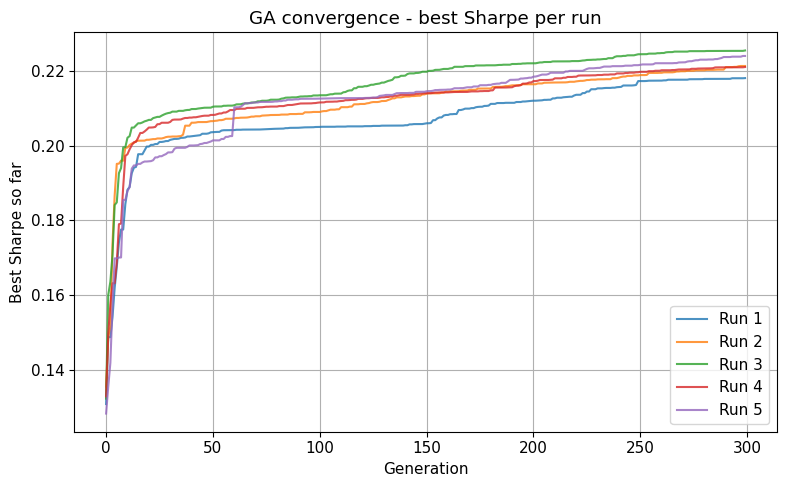

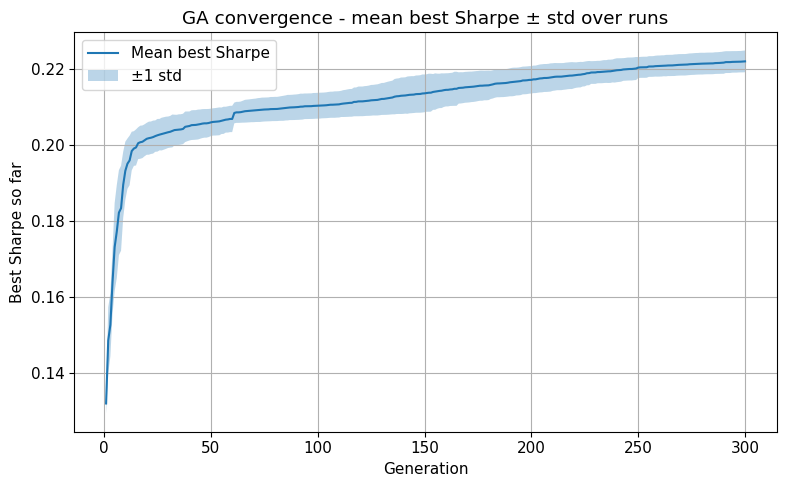

In [31]:
# =====================================
# Cell 5 - Multi-run + convergence plot
# =====================================

def multi_run_ga(n_runs=5, **ga_kwargs):
    all_res = []
    for i in range(n_runs):
        seed = 100 + i  # برای reproducibility
        print(f"=== Run {i+1} with seed {seed} ===")
        res = run_ga(seed=seed, **ga_kwargs)
        print(f"Best Sharpe in run {i+1}: {res['best_fit']:.4f}")
        print("Selected assets:", res["best_asset_names"])
        print("-" * 40)
        all_res.append(res)
    return all_res


def plot_convergence(all_res):
    n_runs = len(all_res)
    n_gen = len(all_res[0]["best_hist"])

    # نمودار همگرایی جداگانه هر اجرا
    plt.figure(figsize=(8, 5))
    for i, res in enumerate(all_res):
        plt.plot(res["best_hist"], label=f"Run {i+1}", alpha=0.8)
    plt.xlabel("Generation")
    plt.ylabel("Best Sharpe so far")
    plt.title("GA convergence - best Sharpe per run")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # میانگین و انحراف معیار بهترین Sharpe در هر نسل
    best_matrix = np.array([res["best_hist"] for res in all_res])  # shape: (n_runs, n_gen)
    mean_best = best_matrix.mean(axis=0)
    std_best = best_matrix.std(axis=0, ddof=1)

    gens = np.arange(1, n_gen + 1)

    plt.figure(figsize=(8, 5))
    plt.plot(gens, mean_best, label="Mean best Sharpe")
    plt.fill_between(gens, mean_best - std_best, mean_best + std_best,
                     alpha=0.3, label="±1 std")
    plt.xlabel("Generation")
    plt.ylabel("Best Sharpe so far")
    plt.title("GA convergence - mean best Sharpe ± std over runs")
    plt.legend()
    plt.tight_layout()
    plt.show()


# اجرای GA با تنظیمات پیشنهادی تمرین
ga_params = dict(
    pop_size=100,
    n_gen=300,
    cx_rate=0.8,
    mut_rate=0.1,
    mut_sigma=0.1,
    tourn_size=3,
    elite_count=2
)

all_results = multi_run_ga(n_runs=5, **ga_params)
plot_convergence(all_results)


=== Global best portfolio over all runs ===
Weekly Sharpe:  0.2255
Annual Sharpe:  1.6261
Selected assets and weights:
COST   -> weight = 0.0673
CVX    -> weight = 0.0628
IBM    -> weight = 0.0767
MRK    -> weight = 0.1591
MSFT   -> weight = 0.0642
NVDA   -> weight = 0.1216
ORCL   -> weight = 0.0642
PEP    -> weight = 0.0692
UNH    -> weight = 0.0727
XOM    -> weight = 0.2421


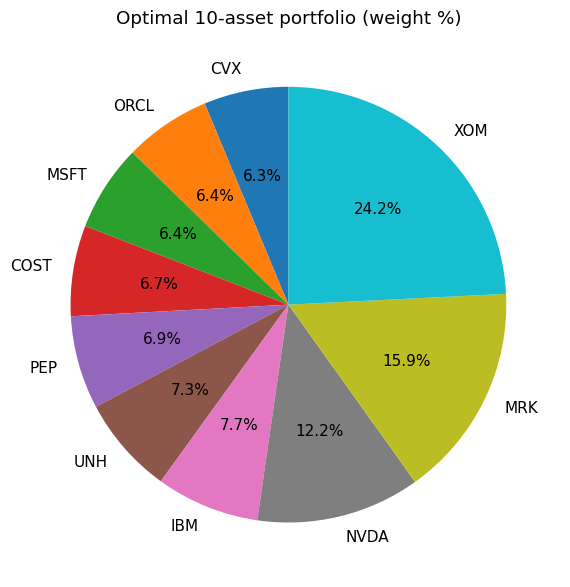

In [32]:
# ==========================================
# Cell 6 - Best overall portfolio & pie plot
# ==========================================

def choose_global_best(all_res):
    best = all_res[0]
    for r in all_res[1:]:
        if r["best_fit"] > best["best_fit"]:
            best = r
    return best

global_best = choose_global_best(all_results)

best_w = global_best["best_weights"]
best_idx = global_best["best_asset_indices"]
best_names = global_best["best_asset_names"]
best_sharpe_weekly = global_best["best_fit"]

# Sharpe سالانه (تقریبی) با فرض ۵۲ هفته در سال
best_sharpe_annual = best_sharpe_weekly * np.sqrt(52)

print("=== Global best portfolio over all runs ===")
print(f"Weekly Sharpe:  {best_sharpe_weekly:.4f}")
print(f"Annual Sharpe:  {best_sharpe_annual:.4f}")
print("Selected assets and weights:")
for name, idx in sorted(zip(best_names, best_idx), key=lambda x: x[0]):
    print(f"{name:5s}  -> weight = {best_w[idx]:.4f}")

# نمودار دایره‌ای (Pie chart) از ۱۰ سهم
weights_nonzero = best_w[best_idx]

plt.figure(figsize=(6, 6))
plt.pie(weights_nonzero,
        labels=best_names,
        autopct="%1.1f%%",
        startangle=90)
plt.title("Optimal 10-asset portfolio (weight %)")
plt.tight_layout()
plt.show()


In [33]:
# ==========================
# Cell 7 - PSO: single run
# ==========================

def run_pso(seed=0,
            swarm_size=60,
            n_iter=300,
            w_inertia=0.7,
            c1=1.5,
            c2=1.5,
            v_max=0.2):
    """
    اجرای یک بار PSO روی مسئله‌ی Sharpe-maximization.

    خروجی:
        - best_ind: بهترین پوزیشن ۵۰تایی (کروموزوم پیوسته)
        - best_fit: بهترین Sharpe
        - best_weights: وزن‌های کامل ۵۰ سهم (جمع=۱، ۱۰ سهم فعال)
        - best_asset_indices: اندیس ۱۰ سهم انتخاب‌شده
        - best_asset_names: نام ۱۰ سهم
        - best_hist: تاریخچه‌ی بهترین Sharpe در هر تکرار
        - mean_hist: میانگین Sharpe در هر تکرار
    """
    np.random.seed(seed)

    # پوزیشن اولیه: یکنواخت در [0,1]
    positions = np.random.rand(swarm_size, n_assets)
    # سرعت اولیه: صفر
    velocities = np.zeros_like(positions)

    # محاسبه‌ی تناسب اولیه
    fitness_values = np.array([fitness(pos) for pos in positions])

    # pbest: بهترین موقعیت فردی
    pbest_positions = positions.copy()
    pbest_values = fitness_values.copy()

    # gbest: بهترین موقعیت کلی
    gbest_idx = np.argmax(fitness_values)
    gbest_position = positions[gbest_idx].copy()
    gbest_value = fitness_values[gbest_idx]

    best_hist = []
    mean_hist = []

    for it in range(n_iter):
        # ذخیره‌ی اطلاعات همگرایی
        best_hist.append(gbest_value)
        mean_hist.append(fitness_values.mean())

        # بروزرسانی هر ذره
        for i in range(swarm_size):
            r1 = np.random.rand(n_assets)
            r2 = np.random.rand(n_assets)

            # بروزرسانی سرعت
            velocities[i] = (w_inertia * velocities[i] +
                             c1 * r1 * (pbest_positions[i] - positions[i]) +
                             c2 * r2 * (gbest_position - positions[i]))

            # محدود کردن سرعت (برای جلوگیری از پرش‌های خیلی بزرگ)
            velocities[i] = np.clip(velocities[i], -v_max, v_max)

            # بروزرسانی پوزیشن
            positions[i] = positions[i] + velocities[i]

            # محدود کردن پوزیشن به [0,1]
            positions[i] = np.clip(positions[i], 0.0, 1.0)

        # محاسبه‌ی تناسب جدید بعد از آپدیت همه
        fitness_values = np.array([fitness(pos) for pos in positions])

        # بروزرسانی pbest برای هر ذره
        better_mask = fitness_values > pbest_values
        pbest_positions[better_mask] = positions[better_mask]
        pbest_values[better_mask] = fitness_values[better_mask]

        # بروزرسانی gbest
        current_gbest_idx = np.argmax(fitness_values)
        current_gbest_value = fitness_values[current_gbest_idx]
        if current_gbest_value > gbest_value:
            gbest_value = current_gbest_value
            gbest_position = positions[current_gbest_idx].copy()

        # (اختیاری) چاپ هر N تکرار
        # if (it + 1) % 50 == 0:
        #     print(f"[PSO] iter {it+1}: best Sharpe = {gbest_value:.4f}")

    # بعد از اتمام
    best_ind = gbest_position
    best_fit = gbest_value
    best_w, best_assets_idx = decode_portfolio(best_ind)

    res = {
        "best_ind": best_ind,
        "best_fit": best_fit,
        "best_weights": best_w,
        "best_asset_indices": best_assets_idx,
        "best_asset_names": [asset_cols[i] for i in best_assets_idx],
        "best_hist": best_hist,
        "mean_hist": mean_hist,
    }

    return res


=== PSO Run 1 with seed 200 ===
[PSO] Best Sharpe in run 1: 0.2049
[PSO] Selected assets: ['IBM', 'ORCL', 'UNH', 'COST', 'PEP', 'CVX', 'MRK', 'AMGN', 'NVDA', 'XOM']
----------------------------------------
=== PSO Run 2 with seed 201 ===
[PSO] Best Sharpe in run 2: 0.2106
[PSO] Selected assets: ['COST', 'MCD', 'ORCL', 'KO', 'PEP', 'UNH', 'CVX', 'MRK', 'NVDA', 'XOM']
----------------------------------------
=== PSO Run 3 with seed 202 ===
[PSO] Best Sharpe in run 3: 0.2137
[PSO] Selected assets: ['COST', 'MSFT', 'PEP', 'IBM', 'ORCL', 'NVDA', 'MRK', 'CVX', 'UNH', 'XOM']
----------------------------------------
=== PSO Run 4 with seed 203 ===
[PSO] Best Sharpe in run 4: 0.2160
[PSO] Selected assets: ['PEP', 'ORCL', 'GE', 'CVX', 'UNH', 'IBM', 'MSFT', 'NVDA', 'XOM', 'MRK']
----------------------------------------
=== PSO Run 5 with seed 204 ===
[PSO] Best Sharpe in run 5: 0.1978
[PSO] Selected assets: ['ORCL', 'COST', 'MCD', 'MSFT', 'PEP', 'IBM', 'GE', 'NVDA', 'UNH', 'XOM']
----------------

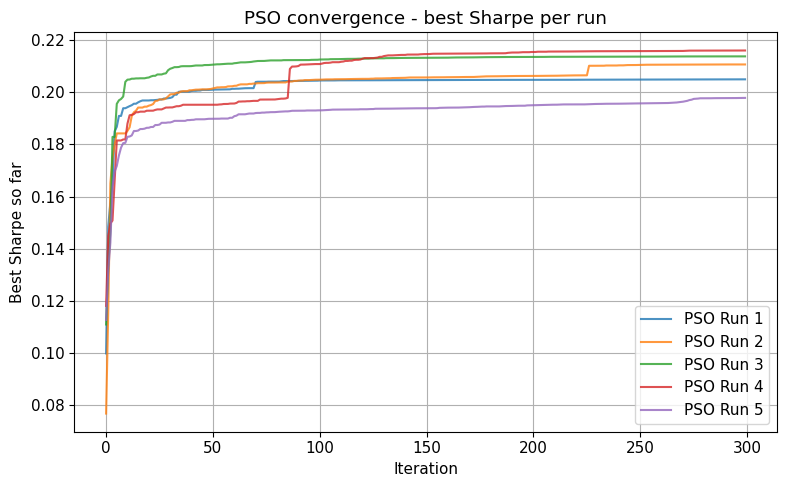

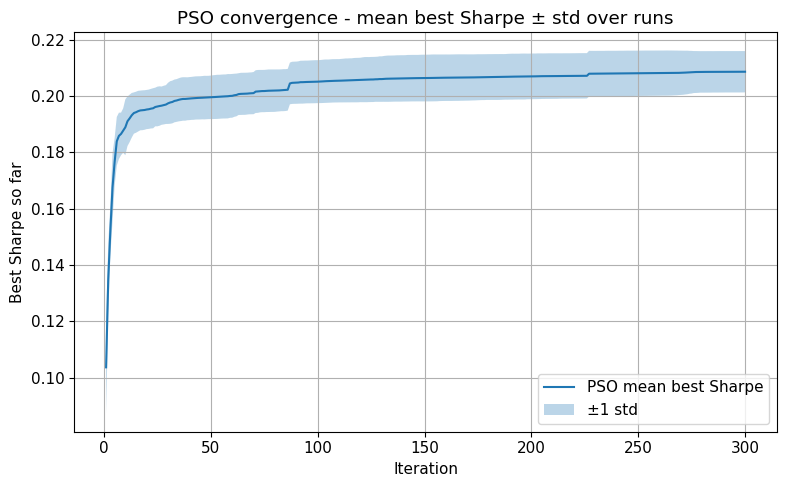

In [34]:
# ==========================================
# Cell 8 - Multi-run PSO + convergence plot
# ==========================================

def multi_run_pso(n_runs=5, **pso_kwargs):
    all_res = []
    for i in range(n_runs):
        seed = 200 + i  # صرفاً برای تفاوت با GA
        print(f"=== PSO Run {i+1} with seed {seed} ===")
        res = run_pso(seed=seed, **pso_kwargs)
        print(f"[PSO] Best Sharpe in run {i+1}: {res['best_fit']:.4f}")
        print("[PSO] Selected assets:", res["best_asset_names"])
        print("-" * 40)
        all_res.append(res)
    return all_res


def plot_convergence_pso(all_res):
    n_runs = len(all_res)
    n_iter = len(all_res[0]["best_hist"])

    # نمودار همگرایی جداگانه هر اجرا
    plt.figure(figsize=(8, 5))
    for i, res in enumerate(all_res):
        plt.plot(res["best_hist"], label=f"PSO Run {i+1}", alpha=0.8)
    plt.xlabel("Iteration")
    plt.ylabel("Best Sharpe so far")
    plt.title("PSO convergence - best Sharpe per run")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # میانگین و انحراف معیار بهترین Sharpe در هر تکرار
    best_matrix = np.array([res["best_hist"] for res in all_res])  # (n_runs, n_iter)
    mean_best = best_matrix.mean(axis=0)
    std_best = best_matrix.std(axis=0, ddof=1)

    iters = np.arange(1, n_iter + 1)

    plt.figure(figsize=(8, 5))
    plt.plot(iters, mean_best, label="PSO mean best Sharpe")
    plt.fill_between(iters, mean_best - std_best, mean_best + std_best,
                     alpha=0.3, label="±1 std")
    plt.xlabel("Iteration")
    plt.ylabel("Best Sharpe so far")
    plt.title("PSO convergence - mean best Sharpe ± std over runs")
    plt.legend()
    plt.tight_layout()
    plt.show()


# پارامترهای PSO
pso_params = dict(
    swarm_size=60,
    n_iter=300,
    w_inertia=0.7,
    c1=1.5,
    c2=1.5,
    v_max=0.2
)

all_results_pso = multi_run_pso(n_runs=5, **pso_params)
plot_convergence_pso(all_results_pso)


In [35]:
all_results_ga = all_results  # از قبل به‌دست آمده از multi_run_ga(...)


In [36]:
# ===========================
# Cell 9 - GA vs PSO summary
# ===========================

def summarize_runs(all_res, label=""):
    best_fits = np.array([r["best_fit"] for r in all_res])
    print(f"=== Summary for {label} ===")
    print(f"Runs: {len(all_res)}")
    print(f"Best Sharpe (max over runs): {best_fits.max():.4f}")
    print(f"Worst Sharpe (min over runs): {best_fits.min():.4f}")
    print(f"Average best Sharpe:         {best_fits.mean():.4f}")
    print(f"Std of best Sharpe:         {best_fits.std(ddof=1):.4f}")
    print("")


summarize_runs(all_results_ga, "GA")
summarize_runs(all_results_pso, "PSO")


=== Summary for GA ===
Runs: 5
Best Sharpe (max over runs): 0.2255
Worst Sharpe (min over runs): 0.2181
Average best Sharpe:         0.2220
Std of best Sharpe:         0.0029

=== Summary for PSO ===
Runs: 5
Best Sharpe (max over runs): 0.2160
Worst Sharpe (min over runs): 0.1978
Average best Sharpe:         0.2086
Std of best Sharpe:         0.0073



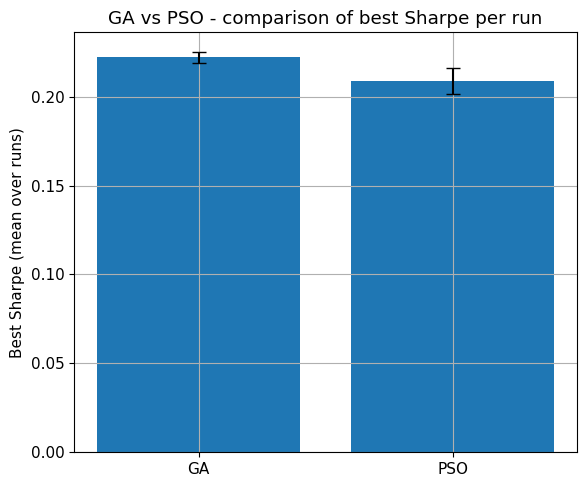

In [37]:
# مقایسه‌ی میانگین بهترین Sharpe در هر اجرا (GA vs PSO)

ga_best_fits = np.array([r["best_fit"] for r in all_results_ga])
pso_best_fits = np.array([r["best_fit"] for r in all_results_pso])

labels = ["GA"] * len(ga_best_fits) + ["PSO"] * len(pso_best_fits)
values = np.concatenate([ga_best_fits, pso_best_fits])

# برای رسم ساده، میانگین هر گروه:
methods = ["GA", "PSO"]
means = [ga_best_fits.mean(), pso_best_fits.mean()]
stds = [ga_best_fits.std(ddof=1), pso_best_fits.std(ddof=1)]

x = np.arange(len(methods))

plt.figure(figsize=(6, 5))
plt.bar(x, means, yerr=stds, capsize=5)
plt.xticks(x, methods)
plt.ylabel("Best Sharpe (mean over runs)")
plt.title("GA vs PSO - comparison of best Sharpe per run")
plt.tight_layout()
plt.show()


In [38]:
# ==============================
# Cell 10 - Pick global bests
# ==============================

def choose_global_best(all_res):
    best = all_res[0]
    for r in all_res[1:]:
        if r["best_fit"] > best["best_fit"]:
            best = r
    return best

global_best_ga = choose_global_best(all_results_ga)
global_best_pso = choose_global_best(all_results_pso)

print("=== Global best GA ===")
print("Weekly Sharpe:", global_best_ga["best_fit"])
print("Assets:", global_best_ga["best_asset_names"])

print("\n=== Global best PSO ===")
print("Weekly Sharpe:", global_best_pso["best_fit"])
print("Assets:", global_best_pso["best_asset_names"])


=== Global best GA ===
Weekly Sharpe: 0.2255007207952803
Assets: ['CVX', 'ORCL', 'MSFT', 'COST', 'PEP', 'UNH', 'IBM', 'NVDA', 'MRK', 'XOM']

=== Global best PSO ===
Weekly Sharpe: 0.21599907999667559
Assets: ['PEP', 'ORCL', 'GE', 'CVX', 'UNH', 'IBM', 'MSFT', 'NVDA', 'XOM', 'MRK']


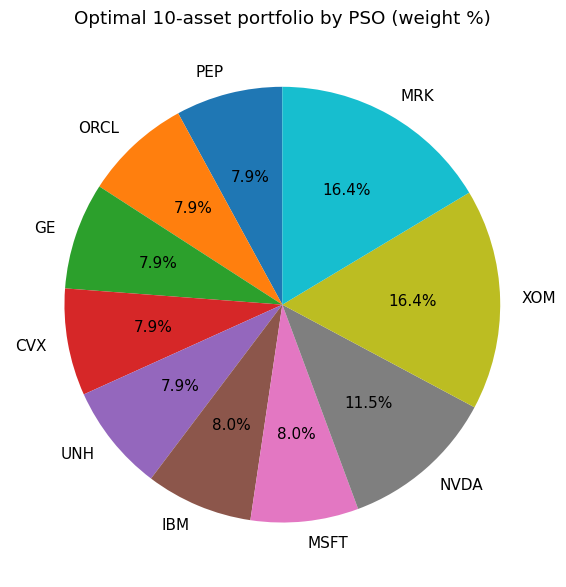

In [39]:
# Pie chart برای بهترین پورتفوی PSO

best_w_pso = global_best_pso["best_weights"]
best_idx_pso = global_best_pso["best_asset_indices"]
best_names_pso = global_best_pso["best_asset_names"]

weights_nonzero_pso = best_w_pso[best_idx_pso]

plt.figure(figsize=(6, 6))
plt.pie(weights_nonzero_pso,
        labels=best_names_pso,
        autopct="%1.1f%%",
        startangle=90)
plt.title("Optimal 10-asset portfolio by PSO (weight %)")
plt.tight_layout()
plt.show()


In [40]:
# ==========================================
# Cell 11 - Generic Sharpe on given dataset
# ==========================================

def sharpe_ratio_on_dataframe(weights, df_any,
                              asset_columns=None,
                              rf_column="Rf"):
    """
    weights: آرایه‌ی وزن ۵۰تایی (همان ساختار قبلی، جمع وزن‌های غیرصفر = ۱)
    df_any:  DataFrame که همان ساختار Dataset اصلی را دارد
    asset_columns: لیست نام ستون‌های سهام (اگر None باشد، از asset_cols سراسری استفاده می‌کنیم)
    rf_column: نام ستون نرخ بدون ریسک
    """
    if asset_columns is None:
        asset_columns = asset_cols

    rets = df_any[asset_columns].values
    rf_any = df_any[rf_column].values.reshape(-1, 1)

    port_ret = rets @ weights  # (T, )
    excess = port_ret.reshape(-1, 1) - rf_any
    excess = excess.ravel()

    mean_excess = excess.mean()
    std_excess = excess.std(ddof=1)
    if std_excess == 0:
        return -1e9

    return mean_excess / std_excess


In [41]:
# =====================================
# Cell 12 - Train vs Test evaluation
# =====================================

# 1) لود دیتای تست
# TA
# df_test = pd.read_csv("Dataset_test.csv")
df_test = pd.read_csv("Dataset.csv")

print("Test data shape:", df_test.shape)

# 2) وزن‌های بهترین GA و بهترین PSO روی دیتا‌ی train (df) از قبل داریم
best_w_ga = global_best_ga["best_weights"]
best_w_pso = global_best_pso["best_weights"]

# 3) Sharpe روی train (همان df اصلی)
sharpe_train_ga = sharpe_ratio_on_dataframe(best_w_ga, df)
sharpe_train_pso = sharpe_ratio_on_dataframe(best_w_pso, df)

# 4) Sharpe روی test
sharpe_test_ga = sharpe_ratio_on_dataframe(best_w_ga, df_test)
sharpe_test_pso = sharpe_ratio_on_dataframe(best_w_pso, df_test)

print("=== GA portfolio evaluation ===")
print(f"Sharpe (train): {sharpe_train_ga:.4f}")
print(f"Sharpe (test) : {sharpe_test_ga:.4f}")

print("\n=== PSO portfolio evaluation ===")
print(f"Sharpe (train): {sharpe_train_pso:.4f}")
print(f"Sharpe (test) : {sharpe_test_pso:.4f}")


Test data shape: (147, 52)
=== GA portfolio evaluation ===
Sharpe (train): 0.2255
Sharpe (test) : 0.2255

=== PSO portfolio evaluation ===
Sharpe (train): 0.2160
Sharpe (test) : 0.2160
